# Тестовое задание N2 #

Перед тобой датасет некой интернет-компании. 

Загрузи его в Python или R, ознакомься с данными и ответь на приведенные ниже вопросы. 

Для ответа на некоторые из них понадобится произвести расчеты, ход которых опиши в файле с кодом.

In [111]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

# Загрузка данных, проверка структуры
data = pd.read_csv('data\summer_camp_data.xls.csv', encoding='cp1251')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52724 entries, 0 to 52723
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                52724 non-null  object 
 1   source              52724 non-null  object 
 2   medium              52724 non-null  object 
 3   delivery_available  52724 non-null  object 
 4   device_type         52724 non-null  object 
 5   promo_activated     52724 non-null  object 
 6   filter_used         52724 non-null  object 
 7   pageviews           52724 non-null  int64  
 8   visits              52724 non-null  int64  
 9   productClick        52724 non-null  int64  
 10  addToCart           52724 non-null  int64  
 11  checkout            52724 non-null  int64  
 12  transactions        52724 non-null  int64  
 13  revenue             52724 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 5.6+ MB


In [112]:
data.head() # оценим, верно ли читаются данные

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0


Не получалось загрузить файл с установками кодировки по умолчанию.

Пользовалась ресурсом https://docs.python.org/3/library/codecs.html#standard-encodings, попробовала несколько вариантов явного указания кодировок для русского языка. Подходящей кодировкой оказалась **cp1251**.

Данные **не содержат пропусков, типы данных числовые и строковые** (в том числе один признак с датой, записанный как строка)

*Последовательно идущие числовые признаки описывают воронку продаж.*

In [113]:
# Преобразование признака с датой в удобный для работы вид
data['date'] = pd.to_datetime(data['date'])


# Количество уникальных значений
data.nunique()

date                    274
source                   24
medium                    6
delivery_available        3
device_type               3
promo_activated           2
filter_used               2
pageviews              4324
visits                 2205
productClick           1373
addToCart              1363
checkout               2022
transactions            497
revenue               21245
dtype: int64

Признаки **medium, delivery_available, device_type, promo_activated, filter_used** будем считать категориальными, так как количество уникальных значений совсем небольшое. 

**Source** - аналогично, но кол-во уникальных значений в несколько раз больше

In [114]:
# Основные статистики по числовым признакам
data.describe()

,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
count,52724.000000,52724.000000,52724.000000,52724.00000,52724.000000,52724.000000,5.272400e+04
mean,445.797853,127.219312,891.086981,178.04074,146.593620,20.092823,2.419841e+04
std,1108.633081,385.094298,2101.027285,419.99282,344.664158,52.436046,6.382118e+04
min,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00
25%,12.000000,2.000000,20.000000,4.00000,3.000000,0.000000,0.000000e+00
50%,47.000000,7.000000,90.000000,18.00000,15.000000,2.000000,2.445500e+03
75%,256.000000,41.000000,520.000000,104.00000,83.000000,11.000000,1.329775e+04
max,26589.000000,6975.000000,32460.000000,6486.00000,3857.000000,1113.000000,1.397420e+06


Для всех признаков видим, что **максимальные значения во много раз превышают средние**. И отклоняются от среднего на величину, большую, чем несколько стандартных отклонений.

Будем иметь это в виду в дальнейшем, скорее всего какие-то данные будут классифицированы как выбросы.

Минимальные значения гораздо ближе к средним, чем максимальные. Оценим распределения на следующем шаге.

array([[<AxesSubplot:title={'center':'pageviews'}>,
        <AxesSubplot:title={'center':'visits'}>,
        <AxesSubplot:title={'center':'productClick'}>],
       [<AxesSubplot:title={'center':'addToCart'}>,
        <AxesSubplot:title={'center':'checkout'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'revenue'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

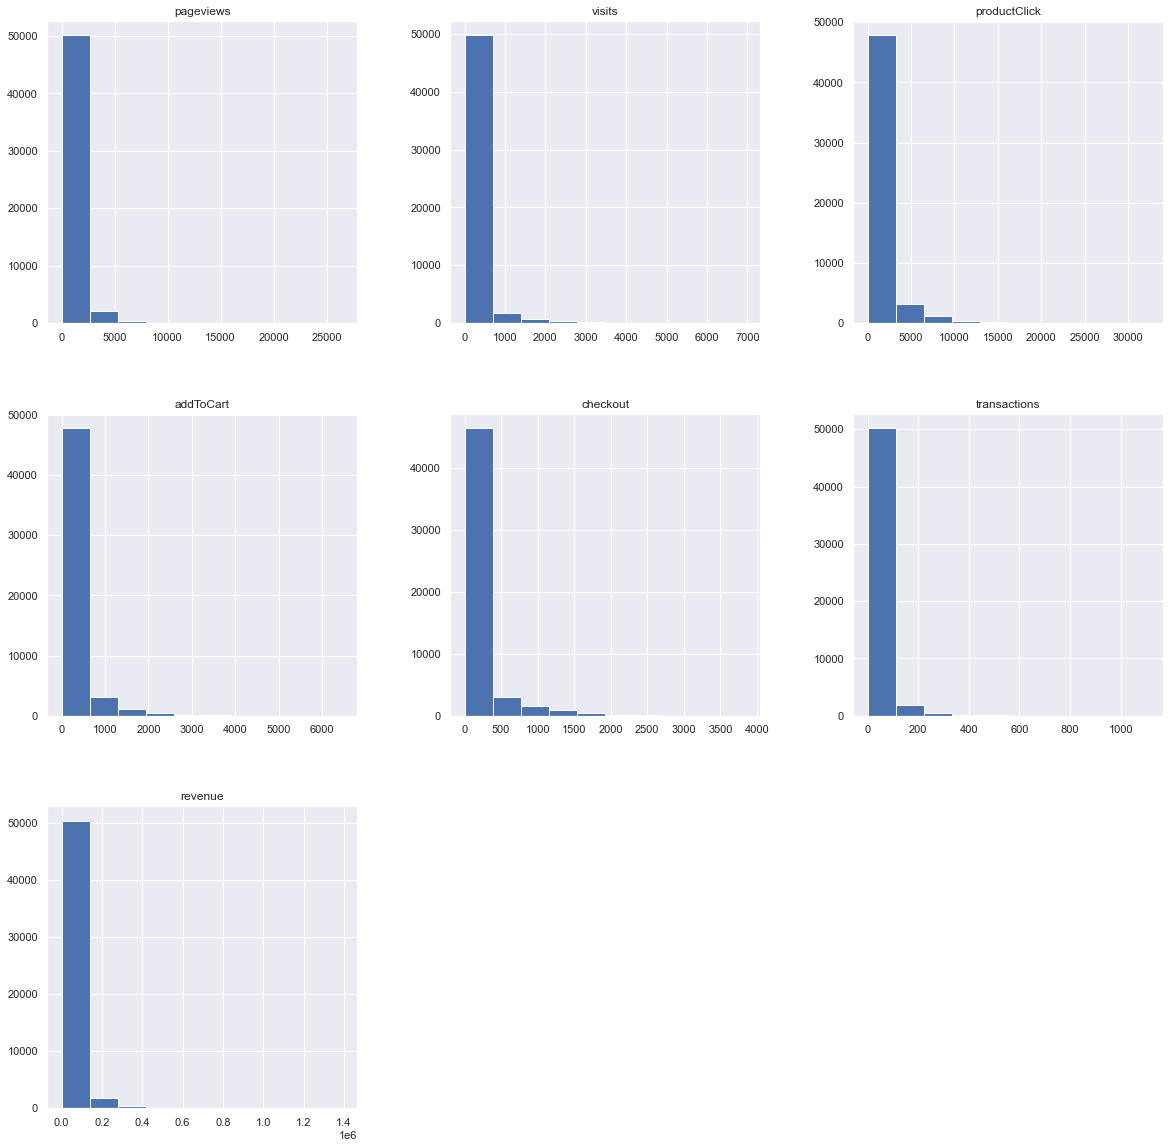

In [115]:
# Распределения числовых признаков
plt.rcParams['figure.figsize'] = (20,20)
data.hist()

Распределения всех признаков ассимметричные

### a. Какой рекламный канал принёс больше всего дохода за всё время?

Text(0.5, 1.0, 'Общий доход по каждому рекламному каналу')

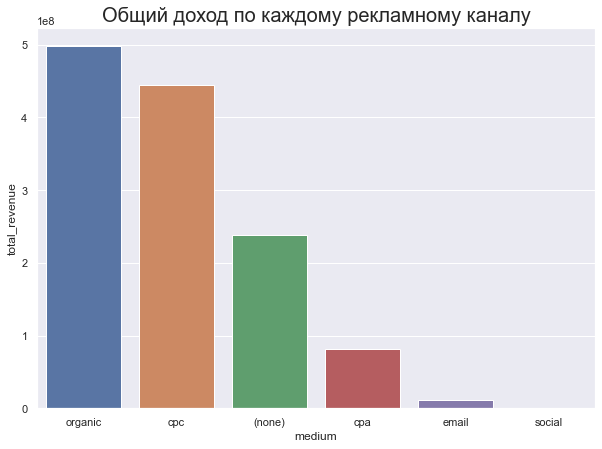

In [116]:
# групировка данных по каналам, расчёт общего дохода, сортировка по доходу по убыванию
grouped = data.groupby('medium', as_index=False).agg(total_revenue=('revenue', 'sum'))
grouped = grouped.sort_values(by='total_revenue', ascending=False)

# график
sns.set_theme()
plt.rcParams['figure.figsize'] = (10,7)

fig = sns.barplot(data=grouped[:10], x='medium', y='total_revenue')
fig.set_title('Общий доход по каждому рекламному каналу', fontdict={'fontsize': 20})


Наибольший доход за всё время принёс **бесплатный канал (органический трафик)**. Затем Контекстная реклама.

Остальные в сумме составляют примерно то же значение, что каждый из первых двух.

### b. Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

In [117]:
# Рассчитаем средний чек
data['mean_check'] = data['revenue'] / data['transactions']

# Рассчитаем дневные значения среднего чека транзакции
data_daily = data.groupby(['date'], as_index=False).agg(checkouts=('checkout', 'sum'),
                                                        transactions=('transactions', 'sum'),
                                                        revenue=('revenue', 'sum'))
data_daily['mean_check'] = data_daily['revenue']/data_daily['transactions']


Text(0.5, 1.0, 'Средний чек транзакции по дням')

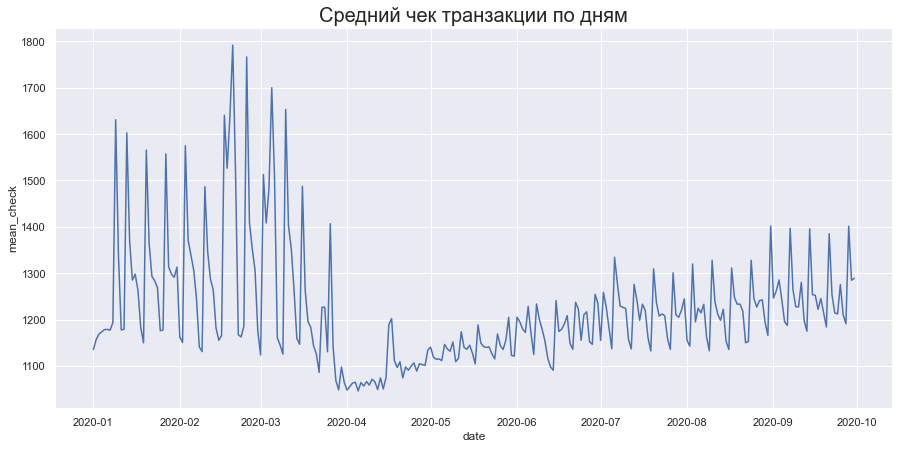

In [118]:
# Введение коронавирусных ограничений полагаю можно отследить по дате
plt.rcParams['figure.figsize'] = (15,7)

# График
fig = sns.lineplot(data=data_daily, x='date', y='mean_check')
fig.set_title('Средний чек транзакции по дням', fontdict={'fontsize': 20})

Интересная динамика, как будто есть некоторая сезонность.

С середины марта видим снижение минимальных и максимальных значений среднего чека, минимумы снизились примерно с 1150 до 1000.

Коронавирусные ограничения первый раз были введены в этот же период.

В начале апреля минимальный разброс и минимальные значения среднего чека транзакции. В середине апреля происходит резкий скачок.

Примерно с мая разброс снова начинает расти, минимальные значения возвращаются на уровень до ограничений, а максимальные - нет.

Июль-август - стабилизация значений и разброса, далее снова небольшой рост.

Text(0.5, 1.0, 'Средний чек транзакции в зависимости от времени')

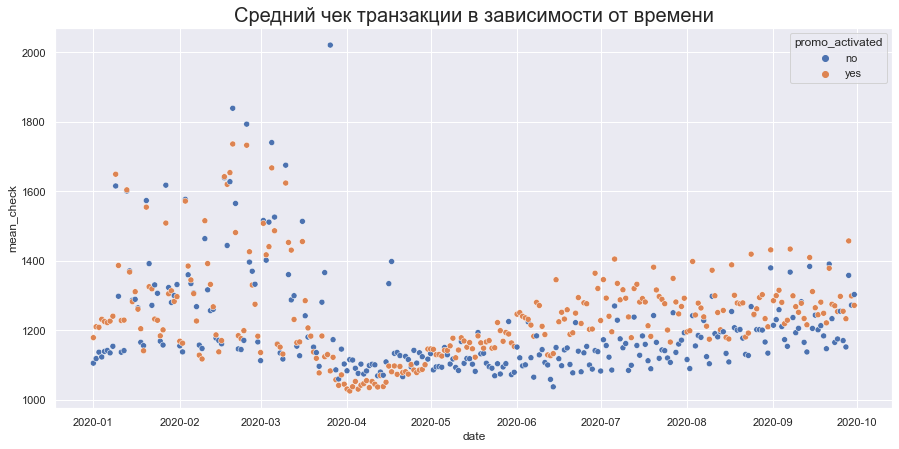

In [108]:
# Ещё один график, который покажет нам дневные средние чеки
# Добавим группировку по использованию промокодов
data_daily_promo = data.groupby(['date', 'promo_activated'], as_index=False).agg(transactions=('transactions', 'sum'),
                                                                                revenue=('revenue', 'sum'))
data_daily_promo['mean_check'] = data_daily_promo['revenue']/data_daily_promo['transactions']


fig = sns.scatterplot(data=data_daily, x='date', y='mean_check', hue='promo_activated')
fig.set_title('Средний чек транзакции в зависимости от времени', fontdict={'fontsize': 20})

До начала ограничений разница между средними чеками транзакции не заметна.

В период ограничений покупки с промокодом имеют более низкий средний чек.

При начиная с мая (с ослаблением ограничений, если правильно помню) значения среднего чека транзакции для покупок с промокодом выше,
и разброс начинает расти, но всё равно не достигает значений уровня начала года.

Минимальные значения чеков для покупок с промокодами стали выше по сравнению с началом года, для покупок без промокодов - чуть ниже.

### c. Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

In [120]:
# Рассчитаем ежедневную конверсию в транзакцию
data_daily['transactions_CR'] = data_daily['transactions'] / data_daily['checkouts'] * 100


# Выделим из даты признак, является ли день выходным
# Опишем функцию, которая для даты определяет, является ли день выходным
def weekend(dmy):
    week_day = dmy.weekday()
    if week_day < 5:
        return 'no' # нумерация дней недели начинается с нуля, 0-4 - будни
    else:
        return 'yes' # иначе выходные

# Создадим соответствующий признак    
data_daily['is_weekend'] = data_daily['date'].apply(weekend)

<AxesSubplot:title={'center':'Конверсия в транзакцию по будним дням и выходным'}, xlabel='transactions_CR', ylabel='is_weekend'>

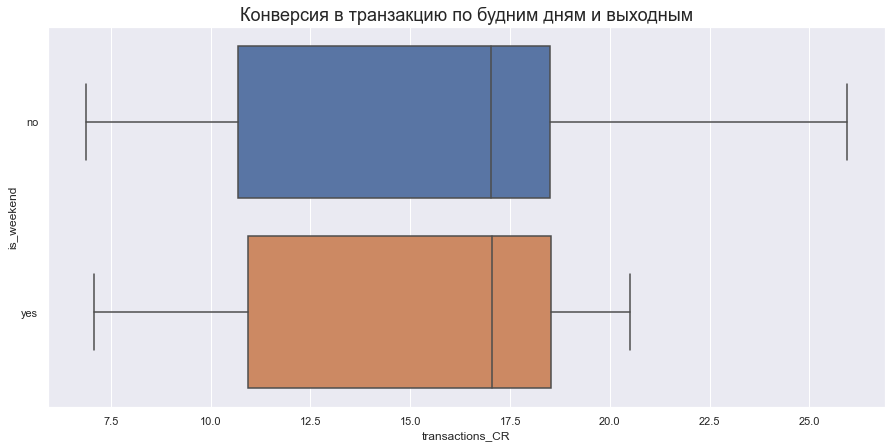

In [121]:
# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 7))
ax1.set_title('Конверсия в транзакцию по будним дням и выходным', fontdict={'fontsize': 18})

sns.boxplot(data=data_daily, x='transactions_CR',
            y='is_weekend', ax=ax1, orient='h')


Медианное **значение конверсии почти не отличается** по выходным и будним дням, минимальные значения, а так же квартили, практически равны.

Заметно отличаются только максимумы. **Это всё справедливо на данной выборке.**

Можем выдвинуть гипотезу о том, что **нет статистически значимых различий** между двумя значениями конверсии **для генеральной совокупности данных**, и проверить её.

Выборки достаточно большие, значения за каждый день можно считать независимыми.
Получается, что распределения конверсий в обеих группах будут стремиться к нормальным с увеличением размера выборок.

**Можем применить z-тест для пропорций,**
он покажет, есть ли статистическая значимость разницы между значениями конверсии в будние дни и выходные.

In [122]:
# Данные для z-теста

# Группировка данных выходные/будни
data_test = data_daily.groupby('is_weekend', as_index=False).agg(sum_checkouts=('checkouts', 'sum'),
                                                                sum_transactions=('transactions', 'sum'),
                                                                count_transactions=('transactions', 'count'))

data_test

,is_weekend,sum_checkouts,sum_transactions,count_transactions
0,no,5076024,691164,196
1,yes,2652978,368210,78


In [123]:
# Собственно z-тест

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в транзакцию в будни и выходные равны'
H1 = 'Конверсия в выходные выше, чем в будни'
alpha = 0.05 # уровень значимости по условию

# значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(count=data_test['sum_transactions'], # число "успехов"
                               nobs=data_test['sum_checkouts'], # общее число наблюдений
                               alternative='larger')

# выводим результат на экран
print('p-value: ', round(p_value, 2))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0)) 

p-value:  1.0
Принимаем нулевую гипотезу. Конверсии в транзакцию в будни и выходные равны


Вероятность совершить ошибку, отвергнув нулевую гипотезу, равна 100%.

Можно сказать с уверенностью, что **конверсии в транзакцию в выходные и в будни равны** (разница статистически не значима для заданного уровня значимости 5% = 100% - 95%).

### Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. 
Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?



В общем случае суммарный **объём дохода зависит от количества транзакций и от среднего чека транзакции**. 

Для оценки этих значений преобразуем наши данные во временной ряд, чтобы одной единице времени соответствовало одно наблюдение каждого признака.

Период прогнозирования достаточно большой, поэтому предлагаю единицей времени выбрать месяц. К тому же данные за каждый день думаю что не покажут нужной картины, будет дисперсия значений выше, и графики получатся не такие гладкие. Сгруппируем данные по месяцам, посмотрим есть ли зависимость от времени:
- общего дохода
- среднего чека на 1 транзакцию
- количества транзакций

и **похожи ли эти зависимости на линейные**.

Попробуем построить эти зависимости.

In [125]:
# Выделим признак Месяц из даты
data['month'] = data['date'].apply(lambda x: x.month)


# Отфильтруем данные по условию medium = cpc
data_cpc = data[data['medium'] == 'cpc']

# Посчитаем по месяцам доход от таких пользователей
data_monthly_cpc = data_cpc.groupby(['month'], as_index=False).agg(transactions=('transactions', 'sum'),
                                                                    revenue=('revenue', 'sum'))
data_monthly_cpc['aver_revenue'] = data_monthly_cpc['revenue'] / data_monthly_cpc['transactions']
data_monthly_cpc

,month,transactions,revenue,aver_revenue
0,1,41418,55498088.0,1339.950939
1,2,44056,61003442.0,1384.679544
2,3,43803,57245201.0,1306.878547
3,4,47693,53971985.0,1131.654226
4,5,47668,55820407.0,1171.024734
5,6,41629,51135137.0,1228.353720
6,7,32101,41131437.0,1281.313261
7,8,29457,36675481.0,1245.051465
8,9,25462,32704761.0,1284.453735


Text(0.5, 1.0, 'Общий доход')

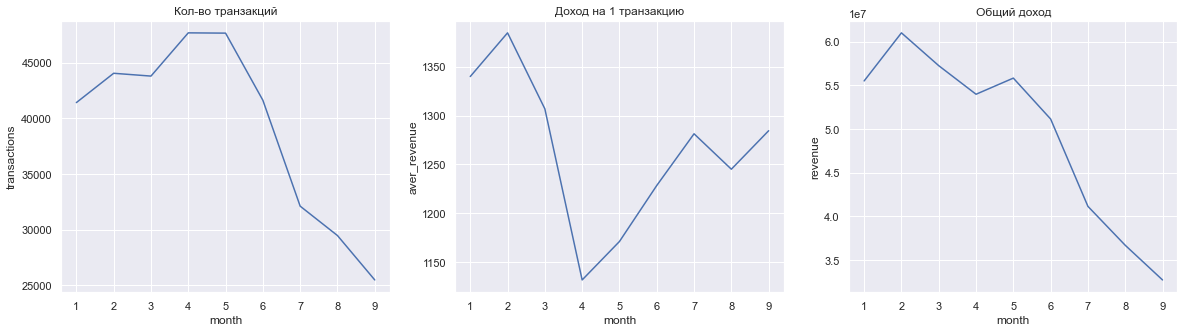

In [126]:
# Оценим характер зависимости по графику
fig, (ax1) = plt.subplots(ncols=3, figsize=(20, 5))

sns.lineplot(data=data_monthly_cpc, x='month', y='transactions', ax=ax1[0])
ax1[0].set_title('Кол-во транзакций')

sns.lineplot(data=data_monthly_cpc, x='month', y='aver_revenue', ax=ax1[1])
ax1[1].set_title('Доход на 1 транзакцию')

sns.lineplot(data=data_monthly_cpc, x='month', y='revenue', ax=ax1[2])
ax1[2].set_title('Общий доход')

Анализируя кол-во транзакций, средний доход на транзакцию и общий доход (меняя параметр y в этом же графике), видим, что
- средний доход на 1 транзакцию в последнее время растёт либо стоит на месте,
- а кол-во транзакций сильно снижается,
- таким образом общий доход тоже снижается, и при сохранении таких темпов падения через 6 мес мы увидим цифру около 0 (визуально).
- **кол-во транзакций гораздо сильнее влияет на средний доход, чем доход на одну транзакцию**

В данном случае хотелось бы понять,
- какие планы у отдела маркетинга по развитию данного канала, **как будет изменяться кол-во транзакций в будущем.**
Если например линейно, то какой период предшествующий период брать для построения линейной регрессии, чтобы предсказать кол-во транзакций.

Альтернативный подход - исследовать зависимость дохода от других имеющихся признаков, и на основании этого построить модель машинного обучения

### Если ты нашел что-то еще интересное в данных, то тоже пиши ;) 

Можно придумать много разрезов для анализа, чтобы изучить данные, но к сожалению время ограничено :)

Из встреченного в результате проведённого анализа, что мне **показалось интересным**:
- исследование сезонности дневного среднего чека транзакции, посмотрим подробнее;
- пользователей, пришедших через Контекстную рекламу вероятно стало меньше, так как кол-во транзакций снизилось. Это потому что фокус на другие каналы в последнее время? Что происходит с органическим трафиком и остальными видами?

Что бы я хотела **показать коллегам из бизнеса** для того, чтобы возможно предпринять какие-то шаги:
- оценить конверсию просмотра страниц в транзакцию, верхний и нижний уровень воронки продаж, изменение конверсии в разрезе раличных факторов для определения "фокусных групп", с кем работать в первую очередь;
- зависимость среднего дохода на транзакцию от разных факторов (описанных всеми существующими признаками), нуждаются ли какие-то группы пользователей в нашем срочном внимании

Text(0.5, 1.0, 'Средний чек транзакции по дням в августе 2020')

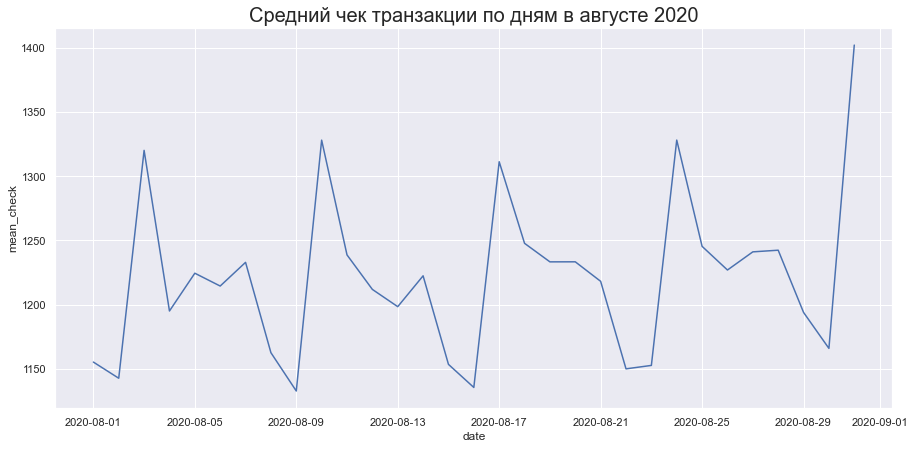

In [127]:
# Выделим признак Месяц из даты
data_daily['month'] = data_daily['date'].apply(lambda x: x.month)

# Возьмём к примеру месяц август
data_daily[data_daily['month']==8]

plt.rcParams['figure.figsize'] = (15,7) # размер графика

# График
fig = sns.lineplot(data=data_daily[data_daily['month']==8], x='date', y='mean_check')
fig.set_title('Средний чек транзакции по дням в августе 2020', fontdict={'fontsize': 20})

Красивые сезонные паттерны :) **Период от минимума до минимума составляет 7 дней**: со 2 по 8 августа, с 9 по 15, с 16 по 22.
По календарю это дни недели с воскресенья по субботу.

Максимумы наблюдаются в понедельники 3, 10, 17 августа. Далее идёт снижение размера среднего чека транзакции, и в середине недели появляется локальный пик.
В выходные видим минимальные значения.

Вероятно в понедельник совершаются оплаты на неделю вперёд

Text(0.5, 1.0, 'Общий доход')

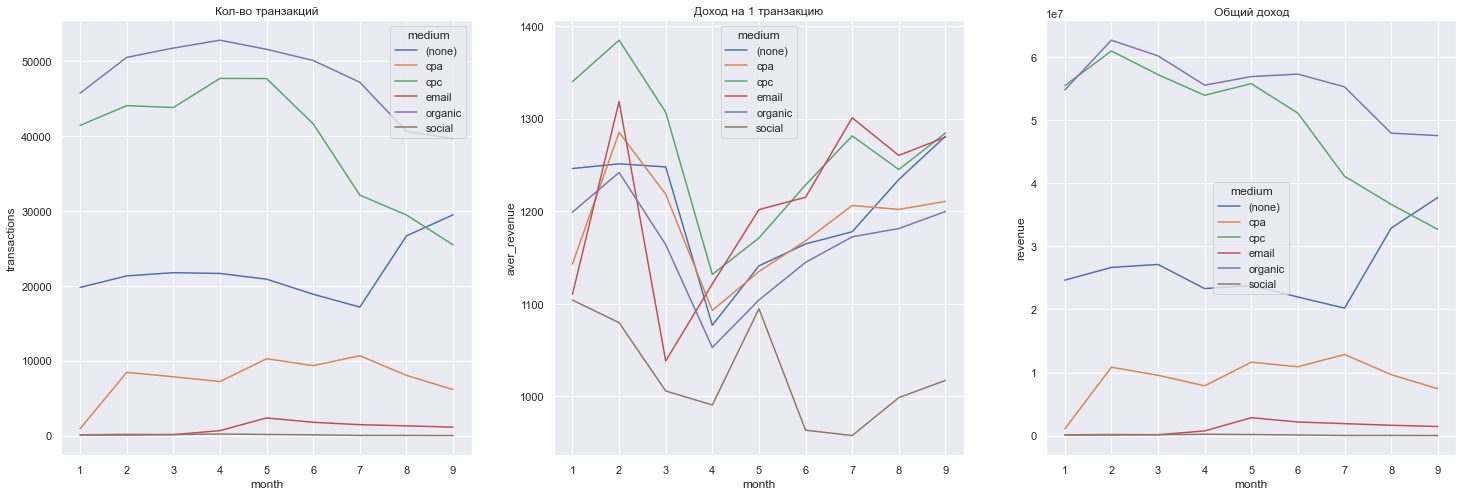

In [129]:
# Что происходит с доходностью на разных каналах рекламы

# Посчитаем по месяцам доход от таких пользователей
data_monthly = data.groupby(['month', 'medium'], as_index=False).agg(transactions=('transactions', 'sum'),
                                                                    revenue=('revenue', 'sum'))
data_monthly['aver_revenue'] = data_monthly['revenue'] / data_monthly['transactions']


# Визуализация
fig, (ax1) = plt.subplots(ncols=3, figsize=(25, 8)) 

sns.lineplot(data=data_monthly, x='month', y='transactions', hue='medium', ax=ax1[0])
ax1[0].set_title('Кол-во транзакций')

sns.lineplot(data=data_monthly, x='month', y='aver_revenue', hue='medium', ax=ax1[1])
ax1[1].set_title('Доход на 1 транзакцию')

sns.lineplot(data=data_monthly, x='month', y='revenue', hue='medium', ax=ax1[2])
ax1[2].set_title('Общий доход')


**Кол-во транзакций:** практически по всем каналам с середины года наблюдаем снижение.
Та же тенденция, что мы видели для канала Контекстной рекламы.

Исключение: канал (none), если правильно понимаю, это ситуации, когда люди напрямую попадают на сайт, например при вводе адреса, и канал CPA.

**Доход на 1 транзакцию:** соцсети выбиваются из общей картины, самый низкий средний доход, и динамика отличается.

По другим каналам рост начиная с апреля, восстановление до уровней начала года.

**Общий доход:** Динамика общего дохода повторяет динамику изменения количества транзакций. Общий доход зависит от кол-ва транзакций в большей степени, чем от дохода на транзакцию